In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [6]:
# Функция загрузки данных Litecoin с дополнительными признаками
def get_litecoin_data():
    ltc = yf.Ticker("LTC-USD")
    df = ltc.history(period="7d", interval="1m")
    df.reset_index(inplace=True)
    df.rename(columns={"Datetime": "date"}, inplace=True)

    # Добавляем временные признаки
    df["hour"] = df["date"].dt.hour
    df["minute"] = df["date"].dt.minute
    df["dayofweek"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month

    # Добавляем лаговые признаки
    for lag in [1, 5, 10, 30, 60]:
        df[f"Close_lag{lag}"] = df["Close"].shift(lag)

    # Скользящее среднее
    df["SMA_10"] = df["Close"].rolling(window=10).mean()
    df["SMA_50"] = df["Close"].rolling(window=50).mean()

    # Волатильность
    df["Volatility"] = df["Close"].rolling(window=10).std()

    return df.dropna()

# Загружаем данные
data = get_litecoin_data()
data.set_index("date", inplace=True)

# Выводим head
print(data.head())

                                Open       High        Low      Close  Volume  \
date                                                                            
2025-03-16 01:15:00+00:00  92.600021  92.600021  92.600021  92.600021   47488   
2025-03-16 01:17:00+00:00  92.548592  92.548592  92.548592  92.548592       0   
2025-03-16 01:18:00+00:00  92.572311  92.572311  92.572311  92.572311       0   
2025-03-16 01:19:00+00:00  92.584724  92.584724  92.584724  92.584724  147008   
2025-03-16 01:20:00+00:00  92.577354  92.577354  92.577354  92.577354   13856   

                           Dividends  Stock Splits  hour  minute  dayofweek  \
date                                                                          
2025-03-16 01:15:00+00:00        0.0           0.0     1      15          6   
2025-03-16 01:17:00+00:00        0.0           0.0     1      17          6   
2025-03-16 01:18:00+00:00        0.0           0.0     1      18          6   
2025-03-16 01:19:00+00:00        0.0 

In [7]:
# Определяем признаки и целевую переменную
features = ["Open", "High", "Low", "Volume", "hour", "minute", "dayofweek", "month", "Close_lag1", "Close_lag5", "Close_lag10", "Close_lag30", "Close_lag60", "SMA_10", "SMA_50", "Volatility"]
target = "Close"
X = data[features]
y = data[target]

# Разделяем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация и обучение модели
model = RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Оценка точности
mae = mean_absolute_error(y_test, model.predict(X_test))
print(f"Средняя абсолютная ошибка: {mae:.5f} USD")

# Функция прогнозирования на несколько интервалов времени
def predict_future_prices(minutes_ahead=[10, 20, 30, 60]):
    global model, data, features
    last_row = pd.DataFrame([data.iloc[-1][features]], columns=features)
    prediction_results = []

    for future_time in minutes_ahead:
        future_index = data.index[-1] + pd.Timedelta(minutes=future_time)
        last_row["hour"] = future_index.hour
        last_row["minute"] = future_index.minute
        last_row["dayofweek"] = future_index.dayofweek
        last_row["month"] = future_index.month
        predicted_price = model.predict(last_row)[0]
        prediction_results.append((future_index, predicted_price))
        print(f"Прогноз на {future_time} минут ({future_index}): {predicted_price:.5f} USD")

    return prediction_results

# Выполняем прогноз
predictions = predict_future_prices()

Средняя абсолютная ошибка: 0.00075 USD
Прогноз на 10 минут (2025-03-22 07:55:00+00:00): 91.25472 USD
Прогноз на 20 минут (2025-03-22 08:05:00+00:00): 91.25475 USD
Прогноз на 30 минут (2025-03-22 08:15:00+00:00): 91.25475 USD
Прогноз на 60 минут (2025-03-22 08:45:00+00:00): 91.25475 USD


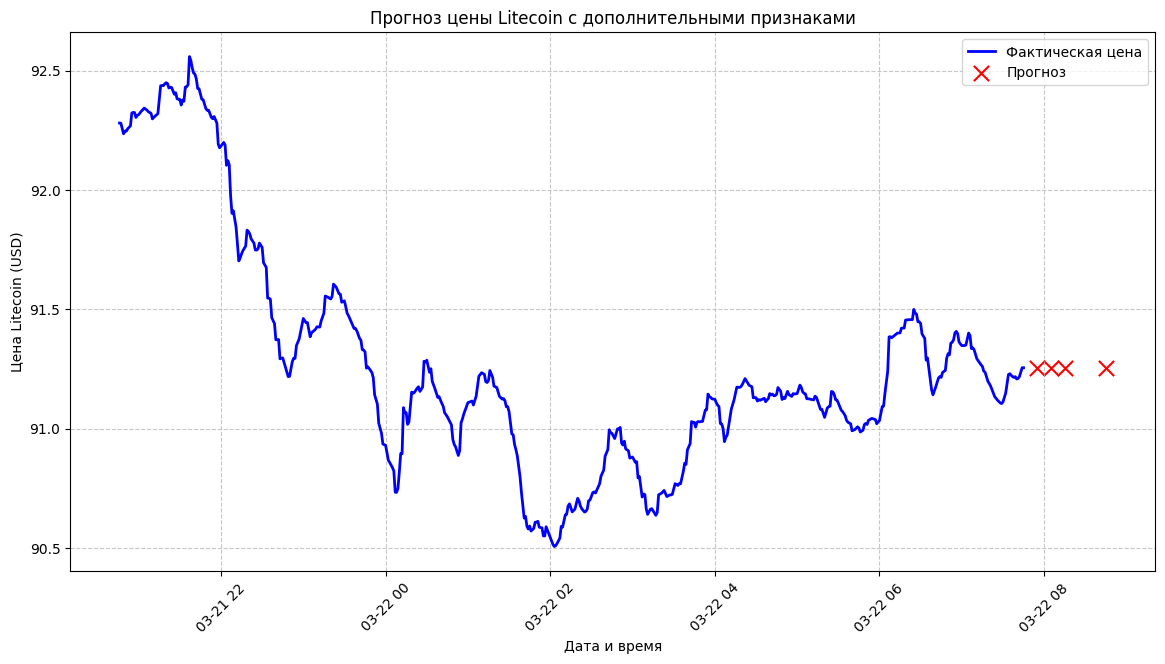

In [8]:
# График
def plot_predictions(data, predictions):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index[-500:], data["Close"].tail(500), label="Фактическая цена", color="blue", linewidth=2)
    times, prices = zip(*predictions)
    plt.scatter(times, prices, color="red", label="Прогноз", marker="x", s=120)
    plt.xlabel("Дата и время")
    plt.ylabel("Цена Litecoin (USD)")
    plt.title("Прогноз цены Litecoin с дополнительными признаками")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.xticks(rotation=45)
    plt.show()

# Построение графика
plot_predictions(data, predictions)